In [2]:
import numpy as np
from utils_clean import generate_sample, DEOptim, RandomOptim, PSOOptim, visualize_meshgrid, get_likelihood_grids, visualize_pred_meshgrid
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

In [3]:
target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)

n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5

X, y = generate_sample(70, n_dims, lower_bound, upper_bound, target_func)

Variation of n_particles

In [7]:
import pandas as pd
df_results = pd.DataFrame({"Iteration":[], "n_particles":[], "t1":[], "t2":[], "Log Likelihood":[]})

In [8]:
n_particles = [5, 10, 20, 40, 65, 100]

for i in range(20):
    for n_p in n_particles:
        pso = PSOOptim(n_iters=10, n_particles=n_p, c1=0.5, c2=0.3, w=0.9, visualize=True)
        gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_pso.fit(X.T, y[...,None])
        df_results.loc[len(df_results)] = [i, n_p, gpr_pso.kernel_.theta[0], gpr_pso.kernel_.theta[1], gpr_pso.log_marginal_likelihood_value_]


2022-08-09 09:30:12,539 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=4.35e+4
2022-08-09 09:30:12,663 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 43530.22554462601, best pos: [-1.70674043 -0.65801801]
2022-08-09 09:30:12,682 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=3.66e+4
2022-08-09 09:30:12,950 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36551.07625281553, best pos: [-0.88633342 -1.43116678]
2022-08-09 09:30:12,975 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=3.57e+4
2022-08-09 09:30:13,347 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35669.28257943817

In [9]:
df_results

,Iteration,n_particles,t1,t2,Log Likelihood
0,0.0,5.0,-1.706740,-0.658018,-43530.225545
1,0.0,10.0,-0.886333,-1.431167,-36551.076253
2,0.0,20.0,-1.169790,-0.916231,-35669.282579
3,0.0,40.0,-1.027531,-1.119937,-34164.594332
4,0.0,65.0,-1.136559,-1.105282,-34435.659775
...,...,...,...,...,...
115,19.0,10.0,-2.506214,-0.609844,-44723.264160
116,19.0,20.0,-0.819044,-1.357602,-36681.918454
117,19.0,40.0,-1.182892,-0.941486,-35345.005710
118,19.0,65.0,-1.149316,-1.014571,-34592.375952


In [10]:
df_results_ = df_results.groupby(['n_particles'], as_index=False).agg({'Log Likelihood':['mean','std']})

In [11]:
df_results_

n_particles Log Likelihood              
                        mean           std
0         5.0  -50676.851886  11469.009446
1        10.0  -41169.139349   8065.911960
2        20.0  -37956.171825   5337.984867
3        40.0  -35051.348776    867.392458
4        65.0  -34480.123090    336.303611
5       100.0  -34441.709079    203.112284

In [14]:
from scipy.stats import t
df_results_["conf_95_o"] = t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood"]["std"] + df_results_["Log Likelihood"]["mean"]
df_results_["conf_95_u"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood"]["std"] + df_results_["Log Likelihood"]["mean"]

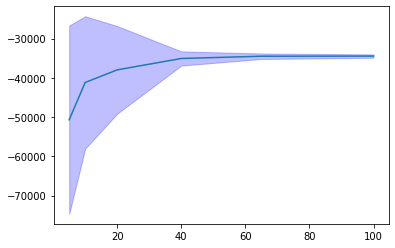

In [17]:
plt.plot(df_results_["n_particles"], df_results_["Log Likelihood"]["mean"])
plt.fill_between(df_results_["n_particles"], df_results_["conf_95_u"], df_results_["conf_95_o"], color="b", alpha=.25)